In [49]:
#*******-------Alexandre Genette Metaheuristic Project-------*****************

In [1]:
#LAUNCH JUPYER WITH COMMAND BELOW OR IT MAY HAVE DIFFICULTY TO EXECUTE THE CODE

In [ ]:
#SOURCE CODE AVAILABLE ON MY GitHUB

https://github.com/alexg06/Jupyter-Sharing/blob/master/Metaheuristic/Project%20Metro%20Genetic%20Algorithm%20Alexandre%20Genette%20A18.ipynb

jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000

In [2]:
#LIBRARIES:
#networkx : is a library used to create directional verteces that will be used in the Genetic Algorithm for optimization later
#numpy : for array management
#pandas : to load *.csv and convert data
#time : to calculate time between iteration and global computation time
#matplotlib.pyplot : for graphs
#copy : for true copy of variables and arrays
#heapq : used in main Loop in order to select best Chromosome from Genetic Algorithm iterations
#math : for calculation

In [3]:
import networkx as nx
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import random
import copy
import heapq
import math

In [4]:
#ORIGINAL FILE WAS CONVERTED INTO DIFFERENT *.csv files
#"project.csv" this is the table with all the connections between stations and the trip duration between
#insideParis" : list of the stations inside paris
#There are 376 rows in project corresponding to connections between 2 stations
#There are 296 single name stations
#There are 54 stations outside Paris
#Finally, Inside Paris there 242 different stations with all a different name

In [5]:
df = pd.read_csv('project_correction.csv', sep =';')
insideParis = pd.read_csv('indexStationParis_corrected.csv', sep =';')

df.tail(3)

,Station,Connection,Time
930,355,354,120
931,366,367,120
932,367,366,120


In [6]:
insideParis.head(3) #dataframe used for stations name

,indexStation,nameStation,NameIndex
0,0,Abbesses,0
1,1,Alexandre Dumas,2
2,2,Alma Marceau,3


In [7]:
#CREATION OF THE GRAPH with networkx, I use a Multiple directed graph, 
# it means that a node can have multiple connections with different nodes and the direction matters
#for example 34 connect with 248 but 248 doesnt connect with 34

In [8]:
MG = nx.MultiDiGraph()

In [9]:
#CREATION OF THE EDGES
#using the df table I create the edges inside the Graph named MG (see above), 
#the weight will be the Time spent between two stations

In [10]:
for i in range(0, len(df.Station)):
    MG.add_edge(df.Station[i], df.Connection[i], weight=df.Time[i])

In [11]:
MG

In [12]:
#THE EDGES ARE REPRESENTED BY A DICTIONNARY

In [13]:
print(MG.adj[0])

{238: {0: {'weight': 41}}, 159: {0: {'weight': 46}}}


In [14]:
#networkx can plot a graph with connections and directions between different nodes

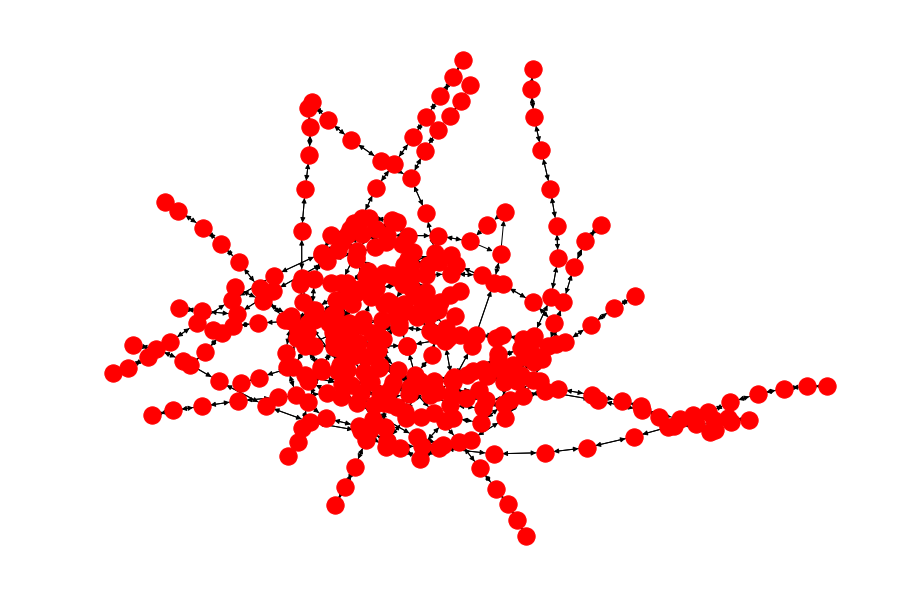

In [18]:
plt.figure(figsize=(12,8))
nx.draw(MG, label=False)

plt.show()

In [19]:
#The Johnson's algorithm will give shortest paths between stations for every verteces
#I used it because it's fast, and usable with weight and directions

https://en.wikipedia.org/wiki/Johnson%27s_algorithm

In [20]:
shortestMulti = nx.johnson(MG)

In [21]:
#EXAMPLE OF A SHORTEST PATH BETWEEN STATION 0 AND 375 thanks to the Johnson's Algorithm
shortestMulti[0][375]

[0, 159, 147, 191, 192, 64, 14, 124, 121, 65, 342, 310, 375]

In [22]:
#MAIN CLASS DEFINITION: Chromosome, it represents a set of nodes(genes).
#******-------------------------------------------------------------------******
#the class function __ini__ is the constructor of the class, it demands a set of stations(index)
#----------------------------------------------------------------------------
#the shuffleGenes is a function in order to shuffle the nodes/genes in the chromosome
#-------------------------------------------------------------------------------
#mutationGene : is a fuction that permits to mutate some gene in the sequence of the chromosome, thanks to a probability  Pm.
#the function "reads" the chromosome from the beginning, nade after node, then a probability is done (randomly), if it is below
#a Threshold Pm that gene will be mutated
#Mutation adds some randomness to a chromosome and brings some variety into the population
#---------------------------------------------------------------------------------
#pathWay : This function creates the optimal pathway between 2 nodes using the dictionnary created with networkx (see above)
#For example between 2 nodes (3,47) the optimal pathway calculated by Johnson's algorithm 
#will be [3, 210, 95, 292, 361, 208, 333, 334, 323, 222, 221, 74, 195, 47]
#THE CHROMOSOME IS ENCODED LIKE THAT
#Chromosome  = |23|45|156|176 etc..... and pathway give the optimal path from 23 to 45, 45 to 156, 156 to 176...... 
#as a numpy.array
#This way, the Genetic Algorithm can optimize the "genes" and there will always be a link between stations
#-----------------------------------------
#__repr__ : it's a function to overload the print function for an object of Chromosome's class
#example
#--------------------
#test = Chromosome([1,2,3,4,5])
#print(test)
#output >> Chromosome :|1|2|3|4|5|

In [23]:
class Chromosome:
    def __init__(self, nodes):
        self.nodes = nodes       
    
    def shuffleGenes(self):
        random.shuffle(self.nodes)   
    
    #Order Changing Mutation, 1 gene is selected thanks to Pm probability
    def mutationGene(self, Pm, inParis):
        self.inParis = inParis
        self.Pm = Pm
        for i in range(0, len(self.nodes)):
            self.randMutate = random.random()
            if self.randMutate < self.Pm:
                self.indexMutation = random.randint(0,len(self.inParis)-1)
                self.mutateTo = self.inParis[self.indexMutation]
                self.nodes[i] = self.mutateTo


    #each gene represents a shortest path between gene i and gene i+1
    def pathWay(self, Multigraph): #Multigraph comes from the Johnson Networkx calculation for shortest path between 2 nodes
        self.Multigraph = Multigraph
        self.totalPath = []
        for i in range(0, len(self.nodes)-1):        
            if i+1 is not None:
                self.totalPath = merge(self.totalPath, self.Multigraph[self.nodes[i]][self.nodes[i+1]])   
        return self.totalPath       
    
    #Overload of the print function to print the chromosome
    def __repr__(self):
        self.strNodes = "Chromosome :"
        for i in self.nodes:
            self.node = str(i)
            self.strNodes = self.strNodes + "|" + self.node
        self.strNodes = self.strNodes + "|"
        return self.strNodes

In [24]:
#FUNCTION PathwayDuration : calculate the path time for a chromosome
#-----------------------------------------------------------------
#PARAMETERS :
#chromosome : the object of class Chromosome to use
#multipath : the Dictionary of shortest path between nodes
#mainDataframe : dataframe with connection between stations and traveling time (here it is called "df")
#Returns the total time in seconds shouldnt be > 72000 (20 hours from 5AM to 1AM)

In [25]:
def PathwayDuration(chromosome, multipath, mainDataframe):
    b = 0
    for i in range(1, len(chromosome.pathWay(multipath))):
        a = np.array(df['Time'].loc[(mainDataframe.Station == chromosome.pathWay(multipath)[i-1]) & 
                               (mainDataframe.Connection == chromosome.pathWay(multipath)[i])].values)
        b = b + a 
    return int(b)

In [26]:
#FUNCTION crossoverSinglePoint:
#A function that returns 1 child chromosome from 2 parents chromosomes
#2 chromosomes are splitted halfway then for example
#Chrom 1 = A|B|C|D and chrom2 = E|F|G|H then we obtain : A|B + G|H
#Child1 = A|B|G|H and if you permute chromosomes in a second call you obtain child2 = E|F|C|D

In [27]:
def crossoverSinglePoint(chromo1, chromo2):
    lenChromo = int(len(chromo1.nodes) / 2)
    childrenChr = np.append(chromo1.nodes[0:lenChromo], chromo2.nodes[lenChromo:len(chromo1.nodes)])
    return childrenChr    

In [28]:
#FUNCTION merge:
#works with np.array
#function can merge 2 list where last element of one(a) is the first element of the second(b)
#for example [1,2,3,4] + [4,5,6] = [1,2,3,4,5,6]
#

In [29]:
def merge(a, b): #a,b are numpy.array
    c = a[:-1] + b[:]
    return c    

In [30]:
#FUNCTION NewNameFit2
#return the score to maximize, 1 = best answer, it means that all stations with a different name, have been visited
#There are 242 stations inside paris with a different name, I divide unique name from the list 
#of the nodes by 242,in order to obtain the score.
#the len() is here to prevent the pathway to go beyond 1200 stations visited 
#that could take more than 20 hours to visit all
#Remark : fitScore = 0 if there is a station visited if the length of the chromosome goes beyond 1200(too long)

In [31]:
def NewNameFit2(uniqueNodeName, chromosome, MultiG, uniqueNodeIndex):
    if len(chromosome.pathWay(MultiG)) < 1200:
        NameList = np.array([])
        for i in chromosome.pathWay(MultiG):
            a, = np.where(uniqueNodeIndex == i)
            NameList = np.append(NameList, uniqueNodeName[a])
            fitScore = len(np.unique(NameList)) / 242 #number of unique station / total unique station(242)
    else:
        fitScore = 0 #score equals 0 if the pathway is too long
    return fitScore

In [32]:
#***********________________________________________******************
#***********___MAIN LOOP OF THE GENETIC ALGORITHM___******************
#***********________________________________________******************
#First a population is generated, a population is a set of chromosome with a sequence of different nodes/genes for each
#population is an array of objects of class Chromosome()
#population will evolve at each iteration of the genetic algorithm
#*****-----------------------------------------------------------------
#Then, from the initial population 2(could be changed) best scores are kept, 
#and From the 10(can be changed) best candidates 18 children are created with the crossover Function according to the function :
# ABCD and EFGH gives ABGH, EFCD,  
#each gene can be mutated with Pm probability, 
#for example if the chromosome has a length of 100 and the probability for a gene to mutate is
#Pm = 0.02 there will an average of 2 genes mutated, can be lower or higher depends of the value of Pm
#***********------------------------------------------------------------
#FINALLY, we obtain a new population composed of Chrildren Chromosome and 
#the 2 best Chromosomes from the former population and each
#chromosome could be mutated (depending of Pm)
#Then the new population will have a new iteration etc.....

In [33]:
#NEW ALGO split avec duplicate CROSSOVER SINGLE POINT
#MAIN LOOP
population = np.array([]) #initialization of the population array
X_opti = np.array([]) #initialization of X axis for the graph
Y_opti = np.array([]) #initialization of Y axis for the graph
fitMax = 0
#CREATION OF THE INITIAL POPULATION
for i in range(0, 100): #100 chromosomes are randomly created first
    tmpNode = np.random.choice(insideParis.indexStation, 80, replace=False)
    tmpC = Chromosome(tmpNode)
    population = np.append(population, tmpC)
#MAIN LOOP here population evolved continuously with crossovers and mutations
#NUMBER OF ITERATION z
for z in range(0,200):
    fitList = np.array([])
    
    #fitList = array of the score of the population
    for i in range(0,len(population)):
        fitList = np.append(fitList, NewNameFit2(insideParis.nameStation, population[i], shortestMulti, insideParis.indexStation))
        if fitList[i] > fitMax:
            fitMax = fitList[i]
            bestSolution = population[i] #selection of the best candidate
    if fitMax > 0.999:
            break
    #select the 10 best chromosomes according to their scores, 
    #the array is ordered from higher to lower score, give 18 children
    IndexfitBest = heapq.nlargest(10, range(len(fitList)), fitList.take)
    population_best = np.take(population, IndexfitBest)
    
    #initialization of the new population with 2 best scored chromosomes
    child = np.array([population_best[0], population_best[1]]) #2 best chromosomes kept
    
    #Creation of the children :
    for u in range(1, len(population_best)):
        crossChr1 = Chromosome(crossoverSinglePoint(population_best[u-1], population_best[u]))
        crossChr2 = Chromosome(crossoverSinglePoint(population_best[u], population_best[u-1]))
        child = np.append(child, crossChr1)
        child = np.append(child, crossChr2)
    population = child
    
    #Mutation
    for mutIter in range(0, len(population)-1):
        rand = random.random()
        if rand < 1:  #we can choose to lower the number of chromosome mutated according to rand probability
            population[mutIter].mutationGene(0.02, insideParis.indexStation) # a mutation has 10% chance to occur
    print(np.max(fitList)) #Print the best score of the best candidate
    X_opti = np.append(X_opti, z) #keep track of iterations
    Y_opti = np.append(Y_opti, np.max(fitList)) #keep track of the best score obtained
print(bestSolution)
print(population)


0.8677685950413223
0.871900826446281
0.871900826446281
0.871900826446281
0.8884297520661157
0.8884297520661157
0.8925619834710744
0.8925619834710744
0.9008264462809917
0.9049586776859504
0.9132231404958677
0.9132231404958677
0.9132231404958677
0.9132231404958677
0.9214876033057852
0.9214876033057852
0.9256198347107438
0.9297520661157025
0.9338842975206612
0.9338842975206612
0.9338842975206612
0.9380165289256198
0.9380165289256198
0.9421487603305785
0.9504132231404959
0.9504132231404959
0.9504132231404959
0.9586776859504132
0.9586776859504132
0.9628099173553719
0.9628099173553719
0.9628099173553719
0.9669421487603306
0.9669421487603306
0.9669421487603306
0.9669421487603306
0.9752066115702479
0.9710743801652892
0.9710743801652892
0.9710743801652892
0.9710743801652892
0.9710743801652892
0.9710743801652892
0.9710743801652892
0.9710743801652892
0.9793388429752066
0.9793388429752066
0.9793388429752066
0.9793388429752066
0.9793388429752066
0.9793388429752066
0.9793388429752066
0.9793388429752

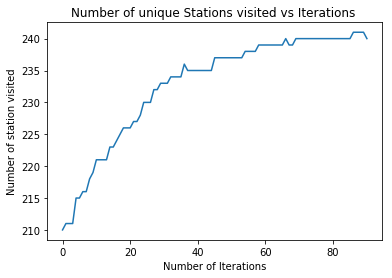

In [45]:
#Thanks to X_opti and Y_opti we can draw the graph
#With the number of iterations on the X axis and the number of different stations visited on the Y axis
plt.figure(figsize=(6,4))
plt.plot(X_opti, Y_opti * 242) #Y axis = maximum name visited
plt.ylabel('Number of station visited')
plt.xlabel('Number of Iterations')
plt.title('Number of unique Stations visited vs Iterations ')
plt.show()

In [ ]:
#Scores of the last iteration

In [34]:
fitList

array([0.98760331, 0.99173554, 0.98760331, 0.98347107, 0.99173554,
       0.99173554, 0.99586777, 0.97107438, 0.97107438, 0.97933884,
       0.99173554, 0.97933884, 0.99173554, 0.98347107, 0.98347107,
       1.        , 0.97107438, 0.97107438, 0.95867769, 0.99173554])

In [36]:
#Score calculation of the best solution
NewNameFit2(insideParis.nameStation, bestSolution, shortestMulti, insideParis.indexStation)

1.0

In [46]:
#DURATION OF THE BEST PATHWAY
print(PathwayDuration(bestSolution,shortestMulti, df )/3600, "hours")

17.861944444444443 hours


In [48]:
#WINNING CHROMOSOME : all genes linked by shortest path (thanks to networkx)
bestSolution

Chromosome :|63|290|3|272|35|184|62|223|3|267|276|359|124|325|160|273|317|24|1|136|251|278|258|269|268|369|63|168|214|78|172|26|160|32|52|320|61|144|129|275|68|168|198|277|247|110|135|294|74|219|58|262|362|275|12|337|263|270|310|240|352|358|323|249|274|109|128|315|257|196|144|251|308|260|256|104|138|271|233|144|

In [47]:
#LIST OF ALL THE STATION TO VISIT
print(bestSolution.pathWay(shortestMulti))
#THE SOLUTION HAS BEEN CHECKED MANUALLY and IT'S OK, all stations connected as requested

[63, 123, 122, 140, 313, 311, 7, 290, 136, 68, 70, 73, 330, 222, 323, 334, 333, 208, 361, 292, 95, 210, 3, 210, 95, 292, 361, 208, 207, 100, 321, 359, 137, 51, 202, 326, 168, 245, 153, 131, 272, 131, 153, 245, 168, 326, 202, 51, 137, 138, 158, 371, 156, 76, 111, 35, 111, 76, 156, 155, 45, 348, 232, 209, 101, 293, 96, 324, 128, 83, 243, 244, 352, 184, 352, 244, 243, 216, 62, 216, 243, 244, 164, 49, 241, 149, 345, 254, 71, 255, 228, 282, 224, 223, 289, 38, 336, 309, 310, 375, 165, 70, 73, 330, 222, 323, 334, 333, 208, 361, 292, 95, 210, 3, 210, 95, 292, 361, 208, 207, 100, 321, 359, 137, 51, 202, 326, 168, 245, 153, 39, 267, 39, 153, 245, 168, 326, 325, 353, 217, 322, 238, 0, 159, 147, 191, 194, 276, 194, 191, 147, 159, 0, 238, 322, 217, 353, 325, 326, 202, 51, 137, 359, 137, 138, 79, 177, 225, 298, 303, 32, 343, 342, 65, 121, 124, 14, 13, 5, 239, 238, 322, 217, 353, 325, 353, 217, 322, 238, 239, 5, 13, 151, 339, 142, 143, 160, 143, 340, 125, 122, 121, 65, 342, 310, 375, 165, 70, 73, 330